In [4]:
import json
import pandas as pd
from operator import itemgetter
from twitter import *


In [11]:
# Loading my authentication tokens
with open('auth_dict','r') as f:
    twtr_auth = json.load(f)

# To make it more readable, lets store
# the OAuth credentials in strings first.
CONSUMER_KEY = twtr_auth['consumer_key']
CONSUMER_SECRET = twtr_auth['consumer_secret']
OAUTH_TOKEN = twtr_auth['token']
OAUTH_TOKEN_SECRET = twtr_auth['token_secret']
    
# Then, we store the OAuth object in "auth"
auth = OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)
# Notice that there are four tokens - you need to create these in the
# Twitter Apps dashboard after you have created your own "app".

# We now create the twitter search object.
t = Twitter(auth=auth)

In [12]:
import sys
import time
from twitter.api import TwitterHTTPError
from urllib.error import URLError
from http.client import BadStatusLine

def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw):
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
        if wait_period > 3600: # Seconds
            print('Too many retries. Quitting.', file=sys.stderr)
            raise e
        if e.e.code == 401:
            return None
        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None
        elif e.e.code == 429:
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                print("Retrying in 15 minutes...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print('...ZzZ...Awake now and trying again.', file=sys.stderr)
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print('Encountered %i Error. Retrying in %i seconds' % (e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function

    wait_period = 2
    error_count = 0
    while True:
        try:
            return twitter_api_func(*args, **kw)
        except TwitterHTTPError as e:
            error_count = 0
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            print("URLError encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            print >> sys.stderr, "BadStatusLine encountered. Continuing."
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise

In [13]:
# This will let us create new partial
# functions with arguments set to 
# certain values.
from functools import partial

# This was maxint.
# There is no longer a maxint (in Python 3)
from sys import maxsize


def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                                friends_limit=maxsize, followers_limit=maxsize):
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None), \
    "Must have screen_name or user_id, but not both"
    
    # You can also do this with a function closure.
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids,
                                count=500)
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids,
                                count=500)
    friends_ids, followers_ids = [], []
    for twitter_api_func, limit, ids, label in [
            [get_friends_ids, friends_limit, friends_ids, "friends"],
            [get_followers_ids, followers_limit, followers_ids, "followers"]
            ]:
        #LOOK HERE! This little line is important.
        if limit == 0: continue
        cursor = -1
        while cursor != 0:
            # Use make_twitter_request via the partially bound callable...
            if screen_name:
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)
            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']
            print('Fetched {0} total {1} ids for {2}'.format(len(ids),
                    label, (user_id or screen_name), file=sys.stderr))
            if len(ids) >= limit or response is None:
                break
    # Do something useful with the IDs, like store them to disk...
    return friends_ids[:friends_limit], followers_ids[:followers_limit]


In [14]:
# initailizeing file
def initialize_file(filename):
    df = pd.DataFrame(columns=['ID','followers'])
    df.to_csv(filename, index=False)

# Our function
def save_friendshipGraph(filename,fid, followers):
    df = pd.DataFrame([[fid, followers]], columns=['ID','followers'])
    
    with open(filename, 'a') as f:
        df.to_csv(f,header=False, index=False)

In [15]:
def crawl_reciprocal_friends(twitter_api, screen_name, limit=500, depth=3):
    initialize_file('friendship.csv')
    # Resolve the ID for screen_name and start working with IDs for consistency
    seed_id = str(twitter_api.users.show(screen_name=screen_name)['id'])
    _, followers_next_queue = get_friends_followers_ids(twitter_api, user_id=seed_id,
                        friends_limit=0, followers_limit=limit)
    
    friends_next_queue, _ = get_friends_followers_ids(twitter_api, user_id=seed_id,
                        friends_limit=limit, followers_limit=0)
    
    reciprocal_friends_queue = list(set(followers_next_queue) & set(friends_next_queue))
    
    most_popular_rf_queue = []
    #getting most followers count
    for u_id in reciprocal_friends_queue:
            follower_count = twitter_api.users.show(user_id=u_id)['followers_count']
            most_popular_rf_queue.append([u_id, follower_count])
    most_popular_rf_queue = sorted(most_popular_rf_queue, key=itemgetter(1),reverse=True)
    print(most_popular_rf_queue)
    most_popular_rf_queue = most_popular_rf_queue[:5]
    reciprocal_friends_queue = [x for x,y in most_popular_rf_queue]
    # Store a seed_id => _follower_ids mapping in MongoDB
    save_friendshipGraph('friendship.csv',seed_id, ','.join([str(x) for x,y in most_popular_rf_queue]))
    next_queue = reciprocal_friends_queue
    d = 1
    # Note that in the example in the next cell,
    # we never enter this loop.
    while d < depth:
        d += 1
        # Reset the next_queue so that we can
        # start building up the next level
        # of followers-of-followers
        (queue, next_queue) = (next_queue, [])
        # Loop through the current
        # level of followers
        for fid in queue:
            
            _, followers_id = get_friends_followers_ids(twitter_api, user_id=fid,
                        friends_limit=0, followers_limit=limit)
    
            friends_id, _ = get_friends_followers_ids(twitter_api, user_id=fid,
                        friends_limit=limit, followers_limit=0)
    
            reciprocal_friends_id = list(set(followers_id) & set(friends_id))
            print("len of recprical friend for " + str(fid) + " :" + str(len(reciprocal_friends_id)))        
            most_popular_rf_id = []
            #getting most followers count
            for u_id in reciprocal_friends_id:
                follower_count = twitter_api.users.show(user_id=u_id)['followers_count']
                most_popular_rf_id.append([u_id, follower_count])
            most_popular_rf_id = sorted(most_popular_rf_id, key=itemgetter(1),reverse=True)
            print(most_popular_rf_id)
            if(len(most_popular_rf_id)>10):
                most_popular_rf_id = most_popular_rf_id[:10]
            else:
                most_popular_rf_id = most_popular_rf_id 
            reciprocal_friends_id = [x for x,y in most_popular_rf_id]
            # Store a seed_id => _follower_ids mapping in MongoDB
            save_friendshipGraph('friendship.csv',str(fid), ','.join([str(x) for x,y in most_popular_rf_id]))
            next_queue += reciprocal_friends_id
            print(next_queue)
    

In [16]:
screen_name = "FCBarcelona"
print(crawl_reciprocal_friends(t, screen_name, depth=1, limit=500))


Fetched 184 total followers ids for 853288753
Fetched 398 total friends ids for 853288753
[[437795283, 1484], [423816291, 1111], [528037924, 1038], [52869614, 901], [413455517, 898], [137776808, 841], [343005437, 705], [328060886, 700], [59517280, 687], [539408318, 668], [346044941, 667], [402245990, 656], [390376335, 647], [51780160, 612], [1183923746, 601], [354915187, 598], [858987763, 590], [308662237, 590], [394440059, 589], [323841169, 588], [199805866, 588], [255163915, 583], [375828759, 583], [48564307, 577], [865554470, 571], [1403883986, 569], [298319786, 566], [21795485, 561], [348600617, 514], [593846283, 507], [87280125, 505], [1044898662, 504], [586001161, 501], [1086791023, 499], [718124079, 485], [1164511819, 484], [456248624, 481], [614455216, 480], [332022037, 479], [90518164, 470], [1190470027, 469], [837440138, 459], [87800431, 456], [356131997, 451], [462490643, 448], [1323695694, 446], [420489123, 443], [969286386, 438], [130664618, 429], [1424368381, 428], [58598

## After Crawling [id] [Followers] are saved in 'friendship.csv' file
## Doing Analysis on this file

In [55]:
import csv
import networkx as nx
import numpy as np

friends_g = nx.Graph()  
def createFriendshipGraph_fromCsv(filename):
    G = nx.Graph()
    with open(filename) as csvfile:
        length = 0
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            edge_list = []
            length = length + 1
            if(length == 1) : continue
            for x in row[1].split(',') :
                if x != '':
                    edge_list.append((int(row[0]),int(x)))
            #print("adding node : " + row[0])
            G.add_node(int(row[0]))
            #print("adding nodes : " + str([x for x in row[1].split(',') if x != '']))
            G.add_nodes_from([int(x) for x in row[1].split(',') if x != ''])
            #print(edge_list)
            G.add_edges_from(edge_list)
            #print("No of Nodes " + str(G.number_of_nodes()))
            #print("No of Edges " + str(G.number_of_edges()))
    return G
friends_g = createFriendshipGraph_fromCsv("friendship.csv")


In [56]:
print("No of edges " + str(friends_g.number_of_edges()))
print("No of nodes " + str(friends_g.number_of_nodes()))


No of edges 131
No of nodes 132


# Performing Community Analysis on it - Applying K-means on it

In [58]:
import matplotlib.pyplot as plt
A = nx.adjacency_matrix(friends_g)
D = np.diag(list(dict(nx.degree(friends_g)).values()))
L = D - A
lmbds,vctrs = np.linalg.eig(L)


In [59]:
indx = [i for i in range(len(lmbds)) if lmbds[i] > .01 and lmbds[i] < .1]
RG_mbd = vctrs[:,indx]


In [60]:
from sklearn.cluster import KMeans
est = KMeans(n_clusters=3)
est

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [61]:
est.fit(RG_mbd)
labels = est.labels_
print(len(labels))

132


C:\Users\Nitesh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


In [62]:
color_map = {0:'blue',1:'red',2:'green'}
node_color = {k:color_map[labels[k]] for k in range(len(labels))}
pos = nx.spring_layout(friends_g)
i = 0 
pos_ = {}
for key,value in pos.items():
    pos_[i] = value
    i = i+1
#print(pos)
print(len(pos))
blue = [i for i in range(114) if labels[i] == 0]
green = [i for i in range(114) if labels[i] == 1]
red  = [i for i in range(114) if labels[i] == 2]


132


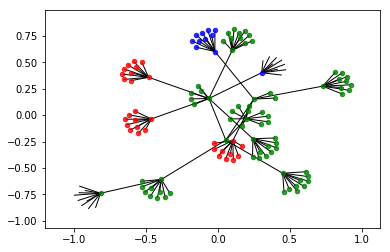

In [63]:
nx.draw_networkx_nodes(friends_g,pos_,nodelist=red,node_color='r',node_size=20,alpha=0.8)
nx.draw_networkx_nodes(friends_g,pos_,nodelist=blue,node_color='b',node_size=20,alpha=0.8)
nx.draw_networkx_nodes(friends_g,pos_, nodelist=green,node_color='g',node_size=20,alpha=0.8)
nx.draw_networkx_edges(friends_g,pos)
plt.show()